# Homework 6 - Regularization of Neural Networks using AD.

***
**Name**: Payoj Jain
***

## Goal

In this assignment you will be implementing and inspecting the effect of the following regularization techniques on neural networks.  
1. L1 Regularization
2. L2 Regularization
3. Random Dropout

This assigment is due for submission on **Tuesday - 03/12/2019, 05:00 PM**.

**NOTE:** Before continuing, I suggest you go through the sources: `optimizer.py` and `mlpnetwork.py` to get to know the convienence methods for loading and saving trained models. Average runtime of this notebook ("Experiment" specifically) is 2-2.5 hours. Manage your time accordingly.   

In [1]:
# import libs
from tensor import Tensor
from optimizer import Optimizer
from mlpnetwork import MLPNetwork
import numpy as np
import copy # you'll need copy for initializing network layers to the same state.

### Implementation

#### Randomly initlalized network weights

In [2]:
class MLP(MLPNetwork):
    def __init__(self, l1_weights, l2_weights):
        super(MLP, self).__init__()
        # Initialize a 3 layer hidden neural network here.
        
        self.l1 = Tensor(copy.deepcopy(l1_weights))
        self.l2 = Tensor(copy.deepcopy(l2_weights))
        
    def forward(self, X):
        """
            Implement the forward pass here.
            Available activations:
            1. ReLU
            2. Sigmoid
            See tensor.py for implementaion details.
            
            return:
            (Tensor) final layer activations/predictions.
        """
        
#         raise NotImplementedError()
        act_l1 = X.dot(self.l1).relu()
        act_l2 = act_l1.dot(self.l2).sigmoid()
        return act_l2

    def update(self, opt):
        opt.step(self)

    def get_L1_norm(self):
        """
            Implement the L1 norm of the layer weights.
            
            Returns:
            (Tensor) L1 norm of the layer weights.
            Make sure you use the AD framework so that the
            norm computation is recorded in the computational
            graph.
            
            
            Check wiki for the definition of L1 norm.
        """
#         raise NotImplementedError()
        return self.l1.abs().sum() + self.l2.abs().sum()
        
    def get_L2_norm(self):
        """
            Implement the L2 norm of the layer weights.
            
            Returns:
            (Tensor) L2 norm of the layer weights.
            Make sure you use the AD framework so that the
            norm computation is recorded in the computational
            graph.
            
            Check wiki for the definition of L2 norm.
        """
#         raise NotImplementedError()
        return (self.l1.pow(2)).sum() + (self.l2.pow(2)).sum()

#### Random Dropout

In [3]:
class MLPDropout(MLPNetwork):
    def __init__(self, l1_weights, l2_weights, drop_out):
        super(MLPDropout, self).__init__()
        # Initialize a 3 layer hidden neural network here.
        
        # Drop out the hidden layer
        self.training = True # Training flag will be needed for Dropout
        self.dropout_p = drop_out # Hyperparameter!
        self.l1 = Tensor(copy.deepcopy(l1_weights))
        self.l2 = Tensor(copy.deepcopy(l2_weights))
        
    def forward(self, X):
        """
            Implement the forward pass with and without
            dropout here. Make sure that your DropOut layer is
            recorded in the computational graph.
            
            Available activations:
            1. ReLU
            2. Sigmoid
            See tensor.py for implementaion details.
            
            return:
            (Tensor) final layer activations/predictions.
        """
        def dropout(X):
            """
                Dropout layer implementation. 
                If training is True 
                    apply dropout layer with keep_prob = self.dropout_p
                Create a Tensor randomly generated binomially with keep_prob.
                Size of Tensor is the layer size for which dropout has to be applied.
            """
            
            if self.training:
                self.mask = Tensor(np.random.binomial(n=1, p=self.dropout_p, size=X.value.shape)/self.dropout_p)
                X = X * self.mask
                self.dropout_layer = X
                
            return X
        
#         X = dropout(X) # Dropout on input layer

        act_l1 = (X.dot(self.l1)).relu()  # relu activation Layer 2
        
        act_l1 = dropout(act_l1) # dropout on hidden layer
            
        act_l2 = (act_l1.dot(self.l2)).sigmoid() # sigmoid activation Layer 3
        
        return act_l2
    
    def update(self, opt):
        opt.step(self)

    def get_L1_norm(self):
        """
            Same as MLP
        """
#         raise NotImplementedError()
        return self.l1.abs().sum() + self.l2.abs().sum()
    
    def get_L2_norm(self):
        """
            Same as MLP
        """
#         raise NotImplementedError()
        return (self.l1.pow(2)).sum() + (self.l2.pow(2)).sum()

#### Dataset

In [4]:
X_train, y_train = np.load('./data/X_train.npy'), np.load('./data/y_train.npy')
X_test, y_test = np.load('./data/X_test.npy'), np.load('./data/y_test.npy')

#### Train and Test loop

In [5]:
def train(model, X_train, y_train, epochs, batch_size, opt, reg_flag, reg_weight = None):
    """
        Train loop.
        
        params:
        model (MLP): 
            An MLP model to be trained. 
            MLP model must inherit the MLPNetwork module.
        X_train (np.ndarray): 
            Training set. 5 features per sample.
        y_train (np.ndarray):
            Training lables. 0 or 1.
        epochs (int): Epochs
        batch_size (int): Batch size
        opt (Optimizer): 
            Only sgd optimizer has been released for obvious reasons.
        reg_flag (int):
            An integer flag for your convienence. Use it to switch between
            different L1, L2 and NO regularization penalties.
        reg_weight ( array of floats ):
            Weight(s) for regularization penalties. 
            You can get creative with this as well. 
            It is an array of floats. Take the hint.
        
        return:
        Implementation choice.
    """
    from sklearn.utils import shuffle
    epoch_error_list = []

    for epoch in range(epochs):
        X, y = shuffle(X_train, y_train)        
        epoch_error = 0
        for batch in range(0,X.shape[0],batch_size):
            
            X_t = X[batch:batch+batch_size]
            y_t = y[batch:batch+batch_size]
            
            y_hat = model.forward(Tensor(X_t))

            # Check the type of regularisation
            if(reg_flag  == 0):
                reg_penalty = Tensor(0)
                error = Tensor(0.5)*((Tensor(y_t) - y_hat).pow(2)).mean()
                
            elif(reg_flag  == 1):
                l1_norm  = model.get_L1_norm()
                reg_penalty = Tensor(reg_weight[0])*(l1_norm)
                error = (Tensor(y_t) - y_hat).abs().mean()
                
            elif(reg_flag == 2):
                l2_norm = model.get_L2_norm()
                reg_penalty = Tensor(0.5*reg_weight[1])*(l2_norm)
                error = Tensor(0.5)*(((Tensor(y_t) - y_hat).pow(2)).mean())
            
            model.zero_grad(opt)
            
            loss = error + reg_penalty
            
            loss.backward()
            
            # Scale the gradients of the hidden layer neurons by dropout mask
            if type(model) == MLPDropout:
                model.dropout_layer.grad *= model.mask.value
            
            model.update(opt)
            
            epoch_error += loss.value
            
        model.update_state_dict()
        
                
        mean_error = epoch_error/(X.shape[0]/batch_size)
        epoch_error_list.append(mean_error)
        
    model.save_state("./data/saved_models/"+model.__class__.__name__+"_"+str(model.l1.value.shape[1])+"_L"+str(reg_flag)+"_norm.pickle")

    return epoch_error_list


def test(X_test, y_test, model):
    """
        Implement this method such that it returns the
        accuracy as the number of correctly classified
        examples in the test set.
        
        params:
        model (MLP): 
            An MLP model to be trained. 
            MLP model must inherit the MLPNetwork module.
        X_test (np.ndarray): 
            Test set. 5 features per sample.
        y_test (np.ndarray):
            Training lables. 0 or 1.
        
    """
    accuracy = 0
    if type(model) == MLPDropout:
        model.training = False
        
    X_test = Tensor(X_test)
    y_hat = model.forward(X_test)
    
    for i in range(len(y_hat.value)):
        if y_hat.value[i] >= 0.5:
            y_hat.value[i] = 1
        else:
            y_hat.value[i] = 0

    for i, y in enumerate(y_hat.value):
        if(y == y_test[i]):
            accuracy += 1
            
    return accuracy*100/len(y_test)

>  ### Dropout implementation
Starting with implementation of dropout layer (in the class MLPDropout under def dropout()). Using the binomial random function, generate a mask, of size of hidden layer, with values 1 or 0 with probability of __'keep_prob'__ of having 1s in the mask. Get the element-wise product of the mask and the activation Tensor. This will give a thin output which is then used in the feed forward. Since, we won't be using dropout while testing we need to scale the dropout layer. For this we need to divide the mask by 'keep_prob'. Also, with addition of the dropout layer, we need to apply dropout to the gradient of the hidden layer also.  

### Experiment

Select a value `lambda_lx` - the regularization parameter for L1 and L2 regularizers, and a `keep_prob` for Random DropOut. Using these values, train the 4 networks (No regularization, L1, L2 and DropOut regularized models respectively) with different number of hidden neurons ranging from 100-1700 in steps of 200. Tabulate the test accuracy of each of the models with same weight initialization and number of neurons in the hidden layer. The resulting table will be a 8x4 matrix.   Summarize your results in a short 280 word report.

In [6]:
n_in = 600                                     # input layer size 
n_hid = [i for i in range(100,1700, 200)]      # hidden layer size
n_out = 1                                      # output layer size

In [7]:
# Initialise random weights
l1_weights = [np.random.randn(n_in, n_h) for n_h in n_hid]
l2_weights = [np.random.randn(n_h, n_out) for n_h in n_hid]

In [8]:
# Same these weights
for i in range(8):
    mlp = MLPNetwork()
    mlp._state['l1'], mlp._state['l2'] = l1_weights[i], l2_weights[i]
    mlp.save_state("./data/saved_models/initialised_MLP_with_hidden_size_"+str((2*i+1)*100)+".pickle")

INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state


In [33]:
keep_prob = 0.5                                # probability for dropout layer
lambda_l1 = 0.01                              # L1 regularisation parameter
lambda_l2 = 0.005                               # L2 regularisation parameter
lambdas = [lambda_l1, lambda_l2]
alpha = 0.5                                    # Learning rate
opt = Optimizer(update_rule='sgd', lr=alpha)   # SGD Optimizer algorithm
epochs = 500
batch_size = 50

In [34]:
# Initialise 8 * 2 MLP Networks with same weights
# ------------ MSE dictionaries for without dropout -------------
mse_no_dropout = dict()
mse_no_dropout['L0'] = dict()
mse_no_dropout['L1'] = dict()
mse_no_dropout['L2'] = dict()

# ------------ Accuracy dictionaries for without dropout --------
accuracy_no_dropout = dict()
accuracy_no_dropout['L0'] = dict()
accuracy_no_dropout['L1'] = dict()
accuracy_no_dropout['L2'] = dict()

In [35]:
# ------------ MSE dictionaries for dropout -------------
mse_dropout = dict()
mse_dropout['L0'] = dict()

# ------------ Accuracy dictionaries for dropout --------
accuracy_dropout = dict()
accuracy_dropout['L0'] = dict()

In [36]:
for i in range(8):
    mlp = MLPNetwork()
    mlp.load_state("./data/saved_models/initialised_MLP_with_hidden_size_"+str((2*i+1)*100)+".pickle")

# ----------------------- TRAINING AND TESTING MODEL WITH DROPOUT LAYER ------------------------------------------------

    l1_weights, l2_weights = mlp._state['l1'], mlp._state['l2']
    model_dropout = MLPDropout(l1_weights, l2_weights, keep_prob)
    mse_dropout['L0'][(2*i+1)*100] = train(model_dropout, X_train, y_train, epochs, batch_size, opt, 0, lambdas)               
    accuracy_dropout['L0'][(2*i+1)*100] = test(X_test, y_test, model_dropout)
    
    for j in range(3):

# ----------------------- TRAINING AND TESTING MODEL WITHOUT DROPOUT LAYER ---------------------------------------------

        l1_weights, l2_weights = mlp._state['l1'], mlp._state['l2']
        model = MLP(l1_weights, l2_weights)
        mse_no_dropout['L'+str(j)][(2*i+1)*100] = train(model, X_train, y_train, epochs, batch_size, opt, j, lambdas)               
        accuracy_no_dropout['L'+str(j)][(2*i+1)*100] = test(X_test, y_test, model)

INFO:MLPNetwork:Initializing model params from file: ./data/saved_models/initialised_MLP_with_hidden_size_100.pickle
INFO:MLPNetwork:Initializing weights using the file: ./data/saved_models/initialised_MLP_with_hidden_size_100.pickle
INFO:MLPNetwork:Initialization complete.
INFO:MLPNetwork:Params loaded: ['_state']
/Users/payoj/Documents/Spring 2019/Neural Nets/Assignments/Regularisation/functions.py:414: RuntimeWarning: overflow encountered in exp
  value = 1.0/(1.0 + np.exp(-self.parents[0].value))
INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:training
DEBUG:MLPNetwork:dropout_p
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2
DEBUG:MLPNetwork:mask
DEBUG:MLPNetwork:dropout_layer
INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2
INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBUG:MLPNetwork:l2
INFO:MLPNetwork:Saving model params.
DEBUG:MLPNetwork:_state
DEBUG:MLPNetwork:l1
DEBU

In [38]:
def print_results():
    print("| Hidden Layer sizes  | 100  | 300  | 500  | 700  | 900  | 1100 | 1300 | 1500 |")
    print("| ------------------- |--------------------- Accuracies -----------------------")
    for i in accuracy_no_dropout:

        x = " No Regularisation " if i == 'L0' else " L1 Regularisation " if i == 'L1' else " L2 Regularisation "
        row = "| "+x+" | "
        for j in accuracy_no_dropout[i]:
            row += str(accuracy_no_dropout[i][j]) + " | "
        print(row)


    x = "      Dropout      "
    row = "| "+x+" | "
    for j in accuracy_dropout['L0']:
        row += str(accuracy_dropout['L0'][j]) + " | "
    print(row)

### Experiments and Observations
After implementation of the model, I experimented on 8 different NN with different Hidden layer size. To investigate how NN behave with/without regularisation (L1, L2) and dropout, I started with very small values of lambdas (1e-6 to 1e-3, 1e-6 to 1e-3), learning rate (1e-4 to 1e-1) for 10 to 50 epochs. These experiments helped me to understand that lambdas and especially learning rates need to be set large (in the order of 1e-2 to 1e-1).  
> #### Experiment 1
__Epochs = 100, lambda1 = 0.001, lambda2 = 0.001, lr = 0.1, keep_prob = 0.7__  
>> __Observations__ : The model performed best having 1500 hidden layer units with L1 regularisation beating all the other norms. This makes sense since L1 tries to achieve the sparse matrix which helps in getting better results.  
Since, accuracies are below 75% I thought to decrease "keep_prob", basically increasing dropouts, increase regularisation parameters and increase learning rate.
> #### Experiment 2
__Epochs = 100, lambda1 = 0.01, lambda2 = 0.01, lr = 0.5, keep_prob = 0.5__  
>> __Observations__ : Models showed a great improvement in accuracies wrt the models in the last experiments. Thus, the hyperparameters chosen are better than the last one. Models with L1 regularisation performed better than other regularisation techniques. Also, there was a significant improvement in Dropout performance (72% from 61%).  
Next, I tried increasing the lambda2 to 0.1 to see how L2 norm model would perform with a large value.  
> #### Experiment 3  
__Epochs = 100, lambda1 = 0.01, lambda2 = 0.1, lr = 0.5, keep_prob = 0.5__
>> __Observations__ : Results show that lambda2 = 0.1 is no good. Accuracy dropped to 50%. This proves that __large value of regularisation parameter may cause underfitting and decreases model's performance__.  
Since, model performance with dropout is much lesser than L1 and L2 norm regularisation, I thought maybe increasing number of epochs may help model with dropout increase its accuracy. 

> #### Experiment 4
__Epochs = 300, l1 = 0.01, l2 = 0.01, lr = 0.5, keep_prob = 0.5__
>> __Observations__ : Since, "keep_prob" is 0.5, __Dropout roughly doubles the number of iterations required to converge__. However, training time for each epoch is less.
As we can see from the results that increasing number of epochs to 300 helped in the performance of the models especially DROPOUT. Also, I observed that __applying dropout layer reduces training time for each epoch as compared to a model applyinf L1 or L2 regularisation.__ It takes 10-15 minutes for 300 epochs for a NN with 1500 hidden layer size for a Dropout Model while it takes around 28-35 minutes for the same paramters, hidden layer size, without dropout but with L2 regularisation.  
> #### Experiment 5
__Epochs = 500, l1 = 0.01, l2 = 0.005, lr = 0.5, keep_prob = 0.5__
>> __Observations__ : With increase in epochs, Model with Dropout showed improvement in performance. This proves the point made above that adding Dropout increases number of iterations required to converge. There's not much improvement in models with L1 and L2 regularisation proving that models without dropout but with regularisation achieve converges faster. 

### Plots and Results 

In [39]:
from matplotlib import pyplot as plt

In [47]:
no_reg_100 = [ 68.3, 74.8, 67.1, 76.3, 74.7, 76.3, 50.9, 51.2]
no_reg_300 = [70.5, 76.5, 80.1, 79.3, 80.5, 49.1, 50.9, 79.6 ]
no_reg_500 = list(accuracy_no_dropout['L0'].values())

L1_reg_100 = [ 90.2, 89.6, 90.6, 90.9, 90.5, 90.3, 89.8, 90.9 ]
L1_reg_300 = [ 90.5, 90.7, 90.6, 90.1, 90.4, 90.7, 90.5, 90.6 ]
L1_reg_500 = [ 90.6, 89.5, 90.4, 90.7, 90.5, 90.1, 90.4, 90.7 ]

L2_reg_100 = [ 50.8, 50.8, 50.8, 50.8, 50.8, 50.8, 50.8, 50.8 ]
L2_reg_300 = [ 88.5, 88.4, 88.8, 87.5, 88.2, 88.8, 88.4, 88.9 ]
L2_reg_500 = [ 87.8, 87.6, 88.7, 87.8, 87.9, 88.0, 87.9, 88.9 ]

dropout_100 = [71.6, 71.4, 65.9, 69.5, 64.4, 71.6, 52.7, 49.2 ]
dropout_300 = [81.1, 80.6, 80.7, 79.3, 82.0, 79.0, 79.1, 82.0 ]
dropout_500 = [85.2, 85.6, 83.7, 83.1, 85.2, 79.1, 83.0, 82.5 ]

In [92]:
no_reg_mse = list(mse_no_dropout['L0'][700])
L1_reg_error = list(mse_no_dropout['L1'][700])
L2_reg_mse = list(mse_no_dropout['L2'][700])
dropout_mse = list(mse_dropout['L0'][700])

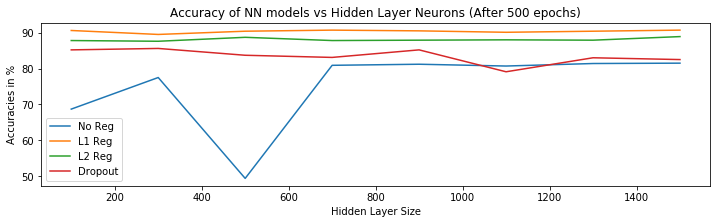

In [69]:
plt.figure(figsize=(12,3))
x_axis = n_hid

plt.plot(x_axis, list(accuracy_no_dropout['L0'].values()), label = 'No Reg')
plt.plot(x_axis, list(accuracy_no_dropout['L1'].values()), label = 'L1 Reg')
plt.plot(x_axis, list(accuracy_no_dropout['L2'].values()), label = 'L2 Reg')
plt.plot(x_axis, list(accuracy_dropout['L0'].values()), label = 'Dropout')

plt.title('Accuracy of NN models vs Hidden Layer Neurons (After 500 epochs)')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Accuracies in %')
plt.legend()
plt.show()

> This graph shows how models with different regularisation and dropout perform with different hidden layer size. We can see that for 500 epochs, model with No regularisation performs worst for any hidden layer size. 

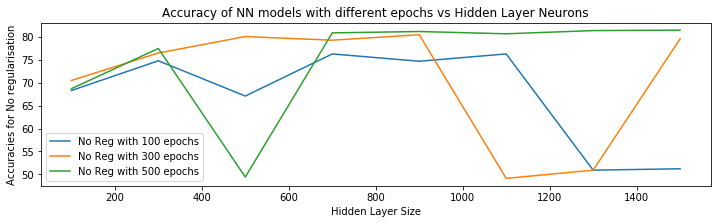

In [84]:
plt.figure(figsize=(12,3))
x_axis = n_hid

plt.plot(x_axis, no_reg_100, label = 'No Reg with 100 epochs')
plt.plot(x_axis, no_reg_300, label = 'No Reg with 300 epochs')
plt.plot(x_axis, no_reg_500, label = 'No Reg with 500 epochs')

plt.title('Accuracy of NN models with different epochs vs Hidden Layer Neurons')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Accuracies for No regularisation')
plt.legend()
plt.show()

>  This graph shows how model with no regularisations perform with different hidden layer size with a constraint of epochs. We can see that after 300 epochs with very large hidden layer size, model with No regularisation starts overfitting. It can be inferred that the optimal number of hidden layer size from this graph is 700.

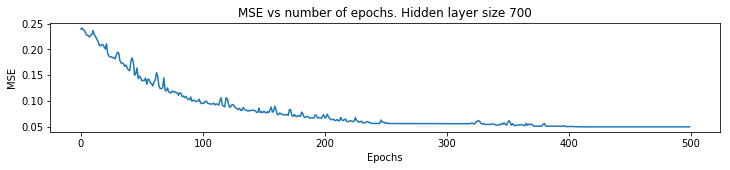

In [91]:
plt.figure(figsize=(12,2))
x_axis = range(500)

plt.plot(x_axis, no_reg_mse)

plt.title('MSE vs number of epochs. Hidden layer size 700')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

> This graphs shows how model with no regularisation converges. As pointed above, after 300 epochs model converges.

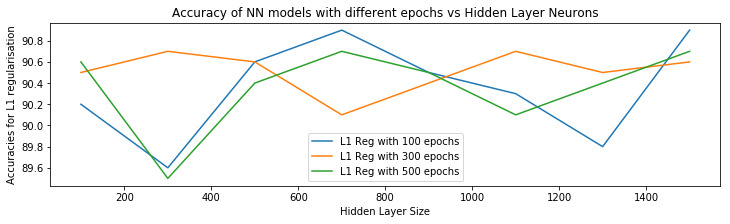

In [66]:
plt.figure(figsize=(12,3))
x_axis = n_hid

plt.plot(x_axis, L1_reg_100, label = 'L1 Reg with 100 epochs')
plt.plot(x_axis, L1_reg_300, label = 'L1 Reg with 300 epochs')
plt.plot(x_axis, L1_reg_500, label = 'L1 Reg with 500 epochs')

plt.title('Accuracy of NN models with different epochs vs Hidden Layer Neurons')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Accuracies for L1 regularisation')
plt.legend()
plt.show()

>  This graph shows how model with L1 regularisations perform with different hidden layer size with a constraint of epochs. It can be inferred that the optimal number of hidden layer size from this graph is 700.

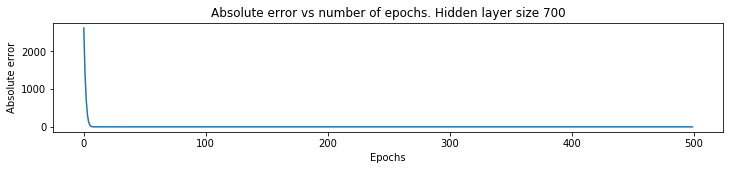

In [87]:
plt.figure(figsize=(12,2))
x_axis = range(500)

plt.plot(x_axis, L1_reg_error)
# plt.plot(x_axis, dropout_500, label = 'dropout with 500 epochs')

plt.title('Absolute error vs number of epochs. Hidden layer size 700')
plt.xlabel('Epochs')
plt.ylabel('Absolute error')
plt.show()

> This graphs shows how model with L1 regularisation converges. It can be seen, after very few epochs model converges. Hence, regularisation helps in reducing iterations for training.

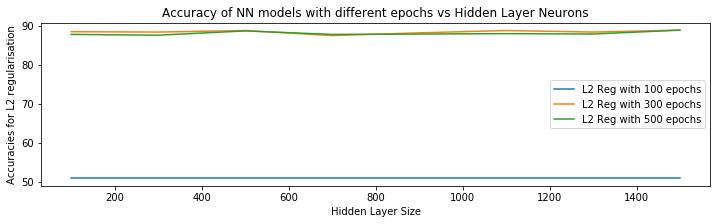

In [65]:
plt.figure(figsize=(12,3))
x_axis = n_hid

plt.plot(x_axis, L2_reg_100, label = 'L2 Reg with 100 epochs')
plt.plot(x_axis, L2_reg_300, label = 'L2 Reg with 300 epochs')
plt.plot(x_axis, L2_reg_500, label = 'L2 Reg with 500 epochs')

plt.title('Accuracy of NN models with different epochs vs Hidden Layer Neurons')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Accuracies for L2 regularisation')
plt.legend()
plt.show()

>  This graph shows how model with L2 regularisations perform with different hidden layer size with a constraint of epochs. Model performance remains almost constant with increase in iterations and increase in hidden layer size.

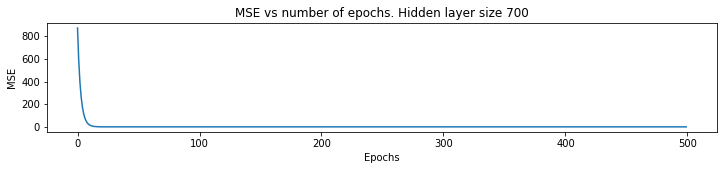

In [88]:
plt.figure(figsize=(12,2))
x_axis = range(500)

plt.plot(x_axis, L2_reg_mse)
# plt.plot(x_axis, dropout_500, label = 'dropout with 500 epochs')

plt.title('MSE vs number of epochs. Hidden layer size 700')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

> This graphs shows how model with L2 regularisation converges. It can be seen, after very few epochs model converges. Hence, regularisation helps in reducing iterations for training.

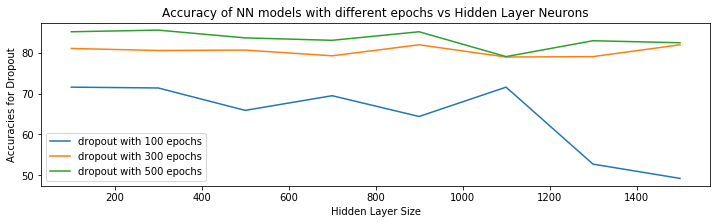

In [78]:
plt.figure(figsize=(12,3))
x_axis = n_hid

plt.plot(x_axis, dropout_100, label = 'dropout with 100 epochs')
plt.plot(x_axis, dropout_300, label = 'dropout with 300 epochs')
plt.plot(x_axis, dropout_500, label = 'dropout with 500 epochs')

plt.title('Accuracy of NN models with different epochs vs Hidden Layer Neurons')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Accuracies for Dropout')
plt.legend()
plt.show()

>  This graph shows how model with Dropout performs with different hidden layer size with a constraint of epochs. With increase in epochs model performance increases. But with increase in hidden layer size model performance tends to decrease. 

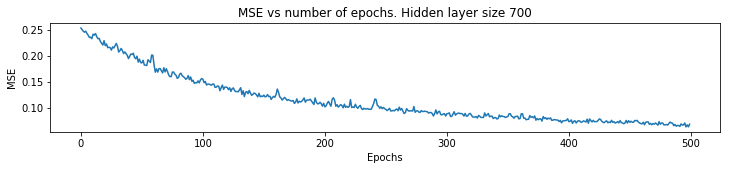

In [83]:
plt.figure(figsize=(12,2))
x_axis = range(500)

plt.plot(x_axis, dropout_mse)
# plt.plot(x_axis, dropout_500, label = 'dropout with 500 epochs')

plt.title('MSE vs number of epochs. Hidden layer size 700')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

> This graphs shows how model with Dropout converges. It can be seen, model is still not  converged even after 500 epochs. This proves that Dropout increases the robustness of the model but also increases the iterations for convergence by a significant factor. Due to hardware and time constraints, I could not perform experiments for over 500 epochs. 